# Jet Clustering

This workflow is for use with the jet samples, that contain both `ClusterTree` and `EventTree` (provided by the `MLTree` utility). This **cannot** handle data where the `EventTree` does not exist, because that contains info on piecing the clusters together into events*, and the baseline jet clustering.

\* This pieceing together can be accomplished in workflows like `EventReconstructionPion.ipynb` but it's rather complex.

#### TODO:

- jet clustering
- comparison of jets

#### 1) Setup

First, let's import a bunch of packages we know we'll need right off-the-bat.

Note that as we've set up our environment with `conda`, our `ROOT` installation has all the bells and whistles. This includes the `pythia8` library and its associated `ROOT` wrapper, `TPythia8`. We can optionally use this for jet-clustering, as it comes `fj-core`.
Alternatively we could use the Pythonic interface for `fastjet` or [pyjet](https://github.com/scikit-hep/pyjet), but the latter requires linking an external fastjet build for speed and this doesn't seem to work when following their documentation.

In [1]:
# Imports - generic stuff

import numpy as np
import ROOT as rt
import uproot as ur
import sys, os, glob, uuid
import subprocess as sub
from pathlib import Path

path_prefix = '/workspace/LCStudies/'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import ml_util as mu # for passing calo images to regression networks
from util import qol_util as qu # for progress bar

Welcome to JupyROOT 6.22/02


In [2]:
# Imports and setup for TensorFlow and Keras.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

# Dictionary for storing all our neural network models that will be evaluated
network_models = {}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [3]:
# setup paths
data_dir = path_prefix + 'data/jet'
classification_dir = path_prefix + 'classifier/Models'
regression_dir = path_prefix + 'regression/Models'
fj_dir = path_prefix + '/setup/fastjet/fastjet-install/lib/python3.8/site-packages'

In [4]:
# ----- Calorimeter meta-data -----
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
nlayers = len(layers)
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
assert(len(len_phi) == nlayers)
assert(len(len_eta) == nlayers)
meta_data = {
    layers[i]:{
        'cell_size':(cell_size_eta[i],cell_size_phi[i]),
        'dimensions':(len_eta[i],len_phi[i])
    }
    for i in range(nlayers)
}

In [5]:
# flat classifiers
print('Loading flat classification models... ')
flat_model_files = glob.glob(classification_dir + '/flat/' + '*.h5')
flat_model_files.sort()
flat_model_names = []
for model in flat_model_files:
    model_name = model.split('model_')[-1].split('_flat')[0]
    print('\tLoading ' + model_name + '... ',end='')
    flat_model_names.append(model_name)
    network_models[model_name] = tf.keras.models.load_model(model)
    print('Done.')

# combo classifier
print('Loading simple combo classification model... ',end='')
combo_model_file = classification_dir + '/simple/' + 'model_simple_do20.h5'
network_models['combo'] = tf.keras.models.load_model(combo_model_file)
print('Done.')

# energy regression networks
print('Loading charged-pion energy regression model... ',end='')
charged_energy_model_file = regression_dir + '/' + 'all_charged.h5'
network_models['e_charged'] = tf.keras.models.load_model(charged_energy_model_file)
print('Done.')

print('Loading neutral-pion energy regression model... ',end='')
neutral_energy_model_file = regression_dir + '/' + 'all_neutral.h5'
network_models['e_neutral'] = tf.keras.models.load_model(neutral_energy_model_file)
print('Done.')

Loading flat classification models... 
	Loading EMB1... Done.
	Loading EMB2... Done.
	Loading EMB3... Done.
	Loading TileBar0... Done.
	Loading TileBar1... Done.
	Loading TileBar2... Done.
Loading simple combo classification model... Done.
Loading charged-pion energy regression model... Done.
Loading neutral-pion energy regression model... Done.


Now we make a "local" copy of the jet data. We will only copy over certain branches, and we will skip any files that don't contain an `eventTree` in them.

In [6]:
data_filenames = glob.glob(data_dir + '/' + '*.root')

# debugging - lets us use a single file to speed stuff up a lot.
#data_filenames = [data_dir + '/' + 'user.angerami.21685345.OutputStream._000062.root']

# our "local" data dir, where we create modified data files
jet_data_dir = path_prefix + 'jets/data'
Path(jet_data_dir).mkdir(parents=True, exist_ok=True)

# Get the original data.
files = {name:rt.TFile(name,'READ') for name in data_filenames}

# Some data files might be missing an EventTree.
# For now, we will skip these because our methods count on an existing EventTree.
delete_keys = []
for key, val in files.items():
    file_keys = [x.GetName() for x in val.GetListOfKeys()]
    if('ClusterTree' not in file_keys or 'EventTree' not in file_keys):
        delete_keys.append(key)

for key in delete_keys: 
    print('Ignoring file:',key,'(no EventTree/ClusterTree found).')
    del files[key]

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from  util import qol_util as qu # for progress bar

# now we make a local copy of the files in the jet_data_dir, keeping only certain branches
active_branches = {}
active_branches['cluster'] = [
    'runNumber',
    'eventNumber',
    'truthE',
    'truthPt',
    'truthEta',
    'truthPhi',
    'clusterIndex',
    'nCluster',
    'clusterE',
    'clusterECalib',
    'clusterPt',
    'clusterEta',
    'clusterPhi',
    'cluster_nCells',
    'cluster_ENG_CALIB_TOT',
    'EMB1',
    'EMB2',
    'EMB3',
    'TileBar0',
    'TileBar1',
    'TileBar2'
]
active_branches['event'] = [
    'runNumber',
    'eventNumber',
    'lumiBlock',
    'NPV',
    'nTruthPart',
    'clusterCount',
    'nCluster',
    'clusterE',
    'clusterPt',
    'clusterEta',
    'clusterPhi',
    'AntiKt4EMTopoJetsPt',
    'AntiKt4EMTopoJetsEta',
    'AntiKt4EMTopoJetsPhi',
    'AntiKt4EMTopoJetsE',
    'AntiKt4LCTopoJetsPt',
    'AntiKt4LCTopoJetsEta',
    'AntiKt4LCTopoJetsPhi',
    'AntiKt4LCTopoJetsE',
    'AntiKt4TruthJetsPt',
    'AntiKt4TruthJetsEta',
    'AntiKt4TruthJetsPhi',
    'AntiKt4TruthJetsE'
]

tree_names = {'cluster':'ClusterTree','event':'EventTree'}
data_filenames = []

l = len(files.keys())
i = 0
qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)

for path, tfile in files.items():
    filename_new = jet_data_dir + '/' + path.split('/')[-1]
    old_trees = {x:tfile.Get(tree_names[x]) for x in tree_names.keys()}
    
    for key, tree in old_trees.items():
        tree.SetBranchStatus('*',0)
        for bname in active_branches[key]: tree.SetBranchStatus(bname,1)
    
    tfile_new = rt.TFile(filename_new,'RECREATE')
    new_trees = {x:old_trees[x].CloneTree() for x in old_trees.keys()}
    tfile_new.Write()
    data_filenames.append(filename_new)
    i += 1
    qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)
    del old_trees
    del new_trees

Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000077.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000308.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000225.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000259.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000457.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000270.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000026.root (no EventTree/ClusterTree found).
Ignoring file: /workspace/LCStudies/data/jet/user.angerami.21717971.OutputStream._000481.root (no EventT

In [7]:
# Access the files & trees with uproot
tree_names = {'cluster':'ClusterTree','event':'EventTree'}
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Now we will loop over our data files. This isn't the most notebook-esque code, but it should avoid "out of memory" issues: As we are dealing with a large amount of data, preparing all the data in memory before operating on it will result in very high memory usage. Thus we will sacrifice a multi-cell approach of preparing all the data step-by-step, in order to make sure we don't load more stuff into memory at a time than we need.

In [8]:
# branch buffer for filling our score trees
    # make our branch buffer
branch_buffer = {
    'charged_likelihood_combo': np.zeros(1,dtype=np.dtype('f8')),
    'clusterE_charged': np.zeros(1,dtype=np.dtype('f8')),
    'clusterE_neutral': np.zeros(1,dtype=np.dtype('f8'))
}

for dfile, trees in ur_trees.items():
    
    print (dfile)
    # prep the calo images
    print('\tPrepping calo images...')
    calo_images = {}
    for layer in layers:
        calo_images[layer] = mu.setupCells(trees['cluster'],layer)
    combined_images = np.concatenate(tuple([calo_images[layer] for layer in layers]), axis=1)

    # prep some extra combined input for energy regression
    print('\tPrepping extra inputs...')
    scaler_e = StandardScaler()
    scaler_cal = StandardScaler()
    scaler_eta = StandardScaler()
    
    e = trees['cluster'].array('clusterE')
    e_calib = trees['cluster'].array('cluster_ENG_CALIB_TOT')
    eta = trees['cluster'].array('clusterEta')
    
    # cleaning for e and e_calib (empirically needed for e_calib to remove values that are too large)
    epsilon = 1.0e-12
    e = np.where(e < epsilon, epsilon, e)
    e_calib = np.where(e_calib < epsilon, epsilon, e_calib)
    
    regression_cols = {}
    regression_cols['s_logE'] = scaler_e.fit_transform(np.log(e).reshape(-1,1))
    regression_cols['s_logECalib'] = scaler_cal.fit_transform(np.log(e_calib).reshape(-1,1))
    regression_cols['s_eta'] = scaler_eta.fit_transform(eta.reshape(-1,1))
    
    s_combined,scaler_combined = mu.standardCells(combined_images, layers)
    regression_input = np.column_stack((regression_cols['s_logE'], regression_cols['s_eta'],s_combined))

    # now find network scores
    print('\tCalculating network outputs...')
    model_scores = {}
    
    print('\t\tClassification... ', end='')
    # 1) flat networks
    for layer in flat_model_names:
        model = network_models[layer]
        model_scores[layer] = model.predict(calo_images[layer])[:,1] # [:,1] based on Max's code, this is input to combo network. Likelihood of being charged (vs. neutral)
    
    # 2) combo network
    name = 'combo'
    model = network_models[name]
    input_scores = np.column_stack([model_scores[layer] for layer in layers])
    model_scores[name] = model.predict(input_scores)[:,1] # likelihood of being charged pion (versus neutral pion)
    print('Done.')
    
    print('\t\tRegression... ', end='')
    # 3) energy regression networks
    name = 'e_charged'
    model = network_models[name]
    model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))
    
    name = 'e_neutral'
    model = network_models[name]
    model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))
    print('Done.')
    
    # Now we should save these scores to a new tree.
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'ScoreTree'
    t = rt.TTree(tree_name, tree_name)
    
    print('Saving network scores to tree ' + tree_name + '... ',end='')    
    # --- Setup the branches using our buffer. This is a rather general/flexible code block. ---
    branches = {}
    for bname, val in branch_buffer.items():
        descriptor = bname
        bshape = val.shape
        if(bshape != (1,)):
            for i in range(len(bshape)):
                descriptor += '[' + str(bshape[i]) + ']'
        descriptor += '/'
        if(val.dtype == np.dtype('i2')): descriptor += 'S'
        elif(val.dtype == np.dtype('i4')): descriptor += 'I'
        elif(val.dtype == np.dtype('i8')): descriptor += 'L'
        elif(val.dtype == np.dtype('f4')): descriptor += 'F'
        elif(val.dtype == np.dtype('f8')): descriptor += 'D'
        else:
            print('Warning, setup issue for branch: ', key, '. Skipping.')
            continue
        branches[bname] = t.Branch(bname,val,descriptor)
    
    # Fill the model score tree, and save it to the local data file.
    nentries = model_scores['combo'].shape[0]
    for i in range(nentries):
        branch_buffer['charged_likelihood_combo'][0] = model_scores['combo'][i]
        branch_buffer['clusterE_charged'][0] = model_scores['e_charged'][i]
        branch_buffer['clusterE_neutral'][0] = model_scores['e_neutral'][i]
        t.Fill()
    
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()
    print('Done.')
    
tree_names['score'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000767.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000113.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000062.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000724.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000762.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000801.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.
/workspace/LCStudies/jets/data/user.angerami.21685345.OutputStream._000897.root
	Prepping calo images...
	Prepping extra inputs...
	Calculating network outputs...
		Classification... Done.
		Regression... 

<ipython-input-8-586a2f4af1f1>:67: RuntimeWarning: overflow encountered in exp
  model_scores[name] = np.exp(scaler_cal.inverse_transform(model.predict(regression_input)))


Done.
Saving network scores to tree ScoreTree... Done.


Now, we want to perform jet-clustering, where we'll use the regressed energies (and the classification score will tell us which regressed energy to use for each cluster).

In [9]:
sys.path.append(fj_dir)
import fastjet as fj

# Jet clustering params
R = 0.4
pt_min = 0.0 # min jet pT (GeV) (appears to be 5.0 GeV for the other jets but we turn it off for now)
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

#energy rescaling (all jet info is saved in keV, not GeV)
energy_scaling = 1.0e3

# branch buffer for our jet tree
branch_buffer = {
    'AntiKt4MLTopoJetsPt':rt.std.vector('float')(),
    'AntiKt4MLTopoJetsEta':rt.std.vector('float')(),
    'AntiKt4MLTopoJetsPhi':rt.std.vector('float')(),
    'AntiKt4MLTopoJetsE':rt.std.vector('float')()
}

for dfile, trees in ur_trees.items():
    
    # event info
    cluster_min = trees['event'].array('clusterCount')
    cluster_max = cluster_min + trees['event'].array('nCluster') - 1
    
    # cluster info (pre-existing) #TODO; we include reco cluster E info for debugging purposes only
    cluster_vec = np.column_stack(tuple(trees['cluster'].arrays(['clusterPt','clusterEta','clusterPhi','clusterE']).values()))
    
    # cluster info (scores)
    cluster_classification = trees['score'].array('charged_likelihood_combo')
    cluster_energies = np.column_stack(tuple(trees['score'].arrays(['clusterE_charged','clusterE_neutral']).values()))
    
    # tree for saving jet info
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'JetTree'
    t = rt.TTree(tree_name, tree_name)
    
    branches = {}
    for key,val in branch_buffer.items():
        branches[key] = t.Branch(key, val)
    
    vec_polar = rt.Math.PtEtaPhiEVector()    
    # loop over events
    nevents = trees['event'].numentries
    for i in range(nevents):
        cluster_idxs = np.linspace(cluster_min[i], cluster_max[i], cluster_max[i] - cluster_min[i] + 1, dtype=np.dtype('i8'))        
        nCluster = cluster_idxs.shape[0]
                
        pseudojets = []
        for j, idx in enumerate(cluster_idxs):
            energy = cluster_energies[idx,0]
            if cluster_classification[idx] < 0.5: energy = cluster_energies[idx,1]
            vec_polar.SetCoordinates(cluster_vec[idx,0],cluster_vec[idx,1],cluster_vec[idx,2],energy)
#             print('\t',energy / cluster_vec[idx,3])
            pseudojets.append(fj.PseudoJet(vec_polar.Px(), vec_polar.Py(), vec_polar.Pz(), vec_polar.E())) # fastjet uses Cartesian as input
        jets = jet_def(pseudojets) # perform jet clustering
        
        # Apply optional minimum jet pT cut
        jet_pt = np.array([jet.pt() for jet in jets])
        jet_indices = np.linspace(0,len(jets)-1,len(jets),dtype=np.dtype('i8'))[jet_pt >= pt_min]
        jets = [jets[i] for i in jet_indices]
        njets = len(jets)
        
        # TODO: save jet info to a TTree
        for key in branch_buffer.keys(): branch_buffer[key].clear()
            
        for j in range(njets):    
#             vec.SetCoordinates(jets[j].pt(), jets[j].eta(), jets[j].phi(), jets[j].e())
#             print(vec.E(), vec.P(), vec.M())
#             #print(jets[j].pt(), jets[j].e())
            branch_buffer['AntiKt4MLTopoJetsPt'].push_back(jets[j].pt() * energy_scaling)
            branch_buffer['AntiKt4MLTopoJetsEta'].push_back(jets[j].eta())
            branch_buffer['AntiKt4MLTopoJetsPhi'].push_back(jets[j].phi())
            branch_buffer['AntiKt4MLTopoJetsE'].push_back(jets[j].e() * energy_scaling)
        
        t.Fill()
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()

tree_names['jet'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Now, we want to match the jets we just clustered with the truth jets, to see how well we've reconstructed things.

Here's how we will perform jet-matching:

- Get the list of all reco jets and truth jets for an event
- Loop through the truth jets
    - Find the closest reco jet within $\Delta R=0.3$, if it exists, and call it a match
        - If we fail to find a match, make a note of this
    - Take the matched reco jet off the list, so we don't match it a 2nd time
    
From matched jets, we will immediately compute $E_\text{reco}/E_\text{true}$ and histogram it (we will *not* be saving the matches directly to a file, for now).

We will perform this process for all the different reco jet definitions in the files, so that we can compare our method's energy resolution to the others'.

In [10]:
def jet_matching(reco_jets, truth_jets, max_distance = 0.3):
    ntruth = len(truth_jets['eta'])
    nreco = len(reco_jets['eta'])
    reco_indices = np.linspace(0, nreco, nreco + 1, dtype = np.dtype('i2'))
    
    #TLorentzVectors for computing deltaR
    vec1 = rt.Math.PtEtaPhiEVector()
    vec2 = rt.Math.PtEtaPhiEVector()

    matched_indices = []
    unmatched_truth = []
    unmatched_reco = []
    
    for i in range(ntruth):
        truth_eta = truth_jets['eta'][i]
        truth_phi = truth_jets['phi'][i]
        vec1.SetCoordinates(0.,truth_eta,truth_phi,0.)
        
        # get distances between this truth jet and all unmatched reco jets
        distances = np.zeros(nreco)
        for j in range(nreco):
            reco_idx = reco_indices[j]
            if(reco_idx < 0):
                distances[j] = -999.
                continue 
            vec2.SetCoordinates(0.,reco_jets['eta'][reco_idx],reco_jets['phi'][reco_idx],0.)
            distances[j] = rt.Math.VectorUtil.DeltaR(vec1,vec2)
            
        # now find the minimum distance, beware of negative values
        # see https://stackoverflow.com/a/37973409
        valid_idx = np.where(distances >= 0.)[0]
        
        if(len(valid_idx) == 0):
            unmatched_truth.append(i)
            continue
        
        match_idx = valid_idx[distances[valid_idx].argmin()]
        matched_indices.append((i, match_idx))
        reco_indices[match_idx] = -1.
    unmatched_reco = reco_indices[reco_indices > -1]
    
    return {'truth_reco':matched_indices, 'unmatched_truth':unmatched_truth, 'unmatched_reco':unmatched_reco}

In [11]:
R_max = 0.3

reco_jet_definitions = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets')
}

truth_jet_definition = 'AntiKt4TruthJets'
jet_energy_ratios = {x:[] for x in reco_jet_definitions.keys()}

for dfile in data_filenames:
    nevents = ur_trees[dfile]['event'].numentries
#     nevents = 10 #TODO: restricting range for debugging
    for i in range(nevents):

        truth_jets = {'eta':ur_trees[dfile]['event'].array(truth_jet_definition + 'Eta')[i],'phi':ur_trees[dfile]['event'].array(truth_jet_definition + 'Phi')[i]}
        reco_jets = {key:{'eta':ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'Eta')[i],'phi':ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'Phi')[i]} for key, jet_def in reco_jet_definitions.items()}
        
        for key, jet_def in reco_jet_definitions.items():
            matching_results = jet_matching(reco_jets[key], truth_jets, max_distance = R_max)
            for match in matching_results['truth_reco']:
                e_truth = ur_trees[dfile]['event'].array(truth_jet_definition + 'E')[i,match[0]]
                e_reco = ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'E')[i,match[0]]
                e_ratio = e_reco / e_truth
                jet_energy_ratios[key].append(e_ratio)
                
jet_energy_ratios = {key:np.array(val) for key,val in jet_energy_ratios.items()}

In [12]:
def SetColor(hist, color, alpha = 0.5):
    hist.SetLineColor(color)
    hist.SetFillColorAlpha(color, alpha)

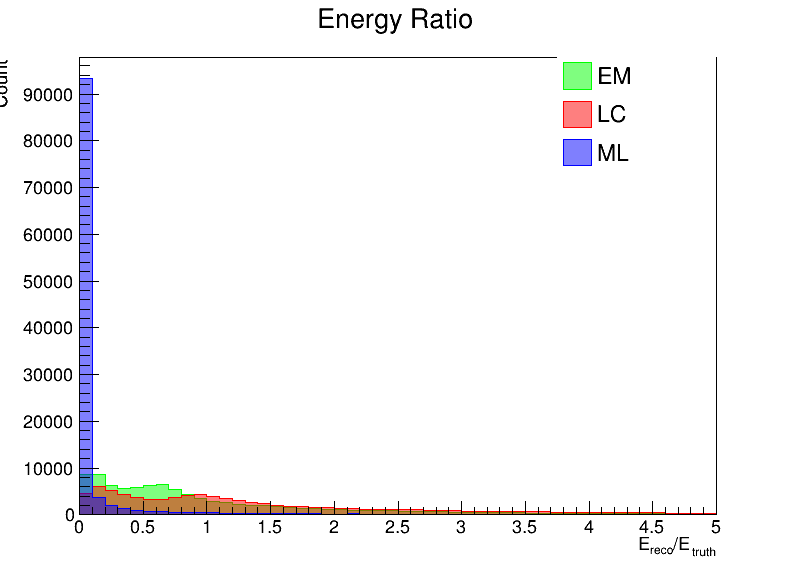

In [13]:
# now plot results

colors = {
    'EM':rt.kGreen,
    'LC':rt.kRed,
    'ML':rt.kBlue
}
min_ratio = 0.
max_ratio = 5.
nbins = 50

hists = {key: rt.TH1F(key + 'ratio', key + ';E_{reco}/E_{true};Count',nbins,min_ratio,max_ratio) for key in reco_jet_definitions.keys()}
for key in colors.keys():
    SetColor(hists[key],colors[key])
    for entry in jet_energy_ratios[key]:
        hists[key].Fill(entry)

c = rt.TCanvas('c_ratio','c_ratio',800,600)
rt.gStyle.SetOptStat(0)
legend = rt.TLegend(0.7,0.7,0.9,0.9)
legend.SetBorderSize(0)

stack = rt.THStack('stack','Energy Ratio;E_{reco}/E_{truth};Count')

for key, hist in hists.items():
    stack.Add(hist)
    legend.AddEntry(hist,key,'f')

stack.Draw('NOSTACK HIST')
legend.Draw()

c.Draw()

Some of the stuff we're seeing above looks weird. From some printouts, it appears that the predicted cluster energies are often too low.

Note that there seems to have been an issue with **units** that I have already accounted for: Based on the magnitude of their values, I think that the truth jets and existing reco jets (EM, LC) had their $p_T$ and energy values stored in keV, not GeV. I have adjusted the ML jets to store their info in keV too to match, and we will convert to GeV for all for plotting.

But even with this rescaling having been done, we see issues such as in the plot above -- the $E_{reco}$ values that we're finding are way too small.

## Verification

To get a better sense of what our data looks like, let's produce some kinematic plots for all flavors of jets. We'll see how the different jet definitions' kinematics compare, and if something is off with our ML jets.

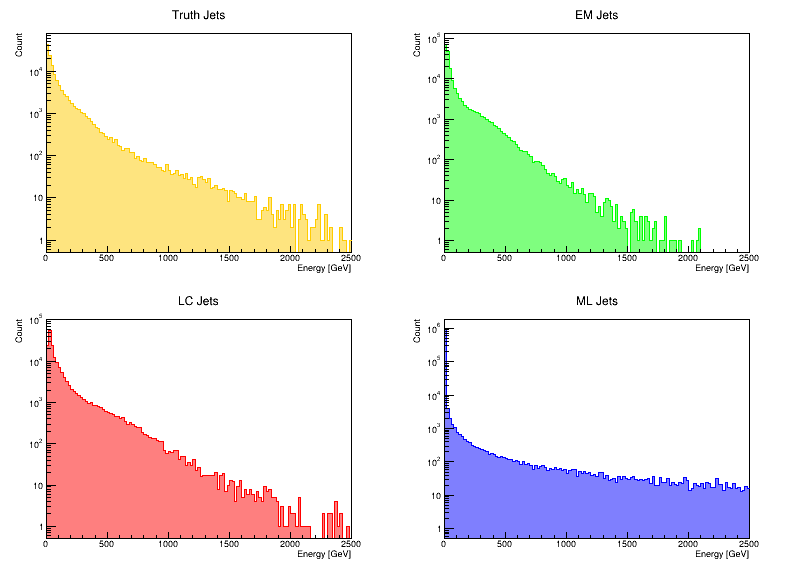

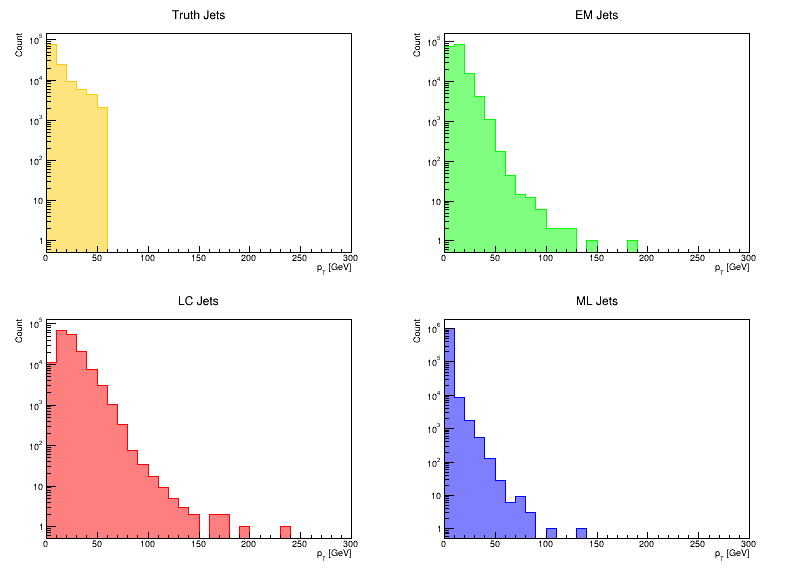

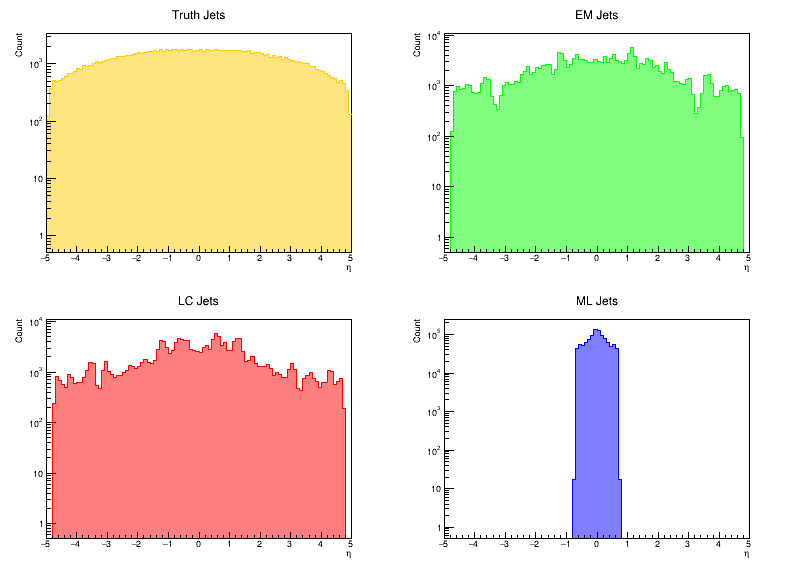

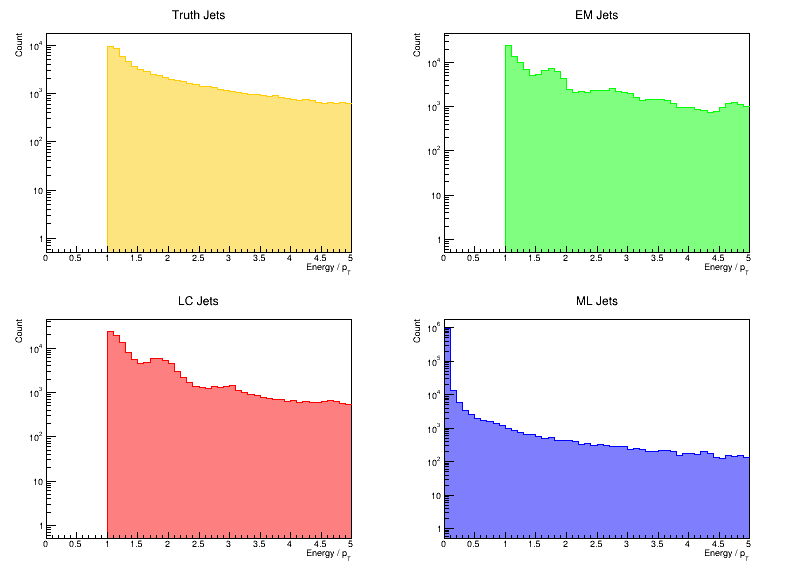

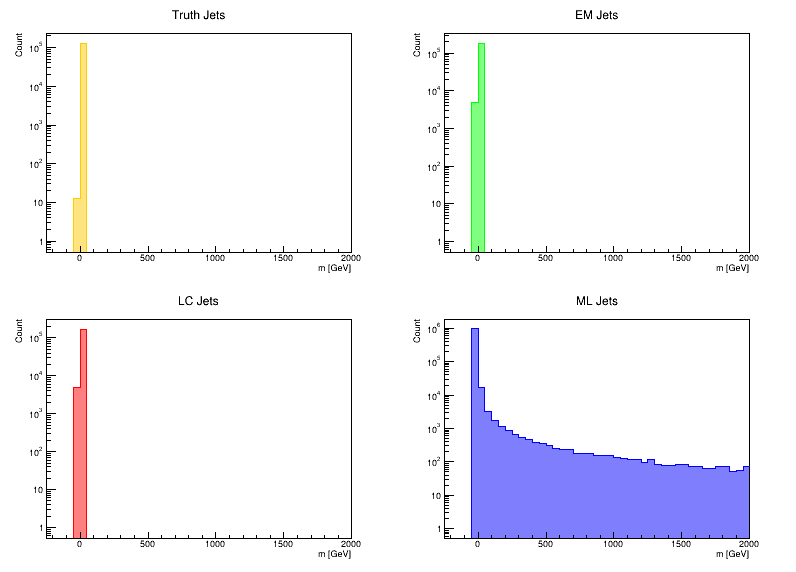

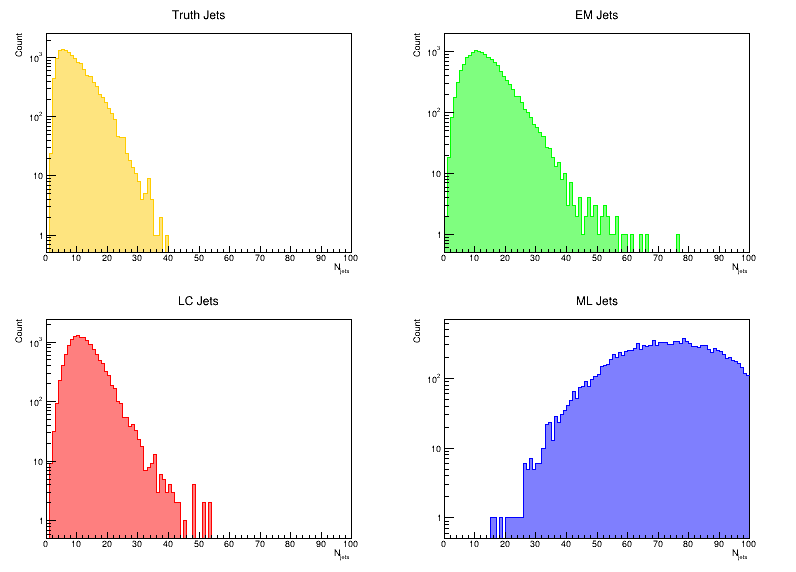

In [36]:
def DrawSet(hists, log=True):
    canvas = rt.TCanvas(str(uuid.uuid4()), str(uuid.uuid4()), 800, 600)
    nx = 2
    l = len(hists.keys())
    ny = int(np.ceil(l / nx))
    canvas.Divide(nx, ny)
    for i, hist in enumerate(hists.values()):
        canvas.cd(i+1)
        hist.Draw('HIST')
        if(log): 
            rt.gPad.SetLogy()
            hist.SetMinimum(5.0e-1)
        else:
            hist.SetMinimum(0.)
    return canvas

# plotting various jet energies divided by pT
jet_defs = {
    'Truth':('event','AntiKt4TruthJets'),
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets')
}

colors = {
    'Truth': rt.kOrange,
    'EM': rt.kGreen,
    'LC': rt.kRed,
    'ML': rt.kBlue
}

scale_factors = 0.001 # jet info seems to be in keV, we want to plot it all in GeV

energy_hists = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy [GeV];Count', 125, 0., 2500.) for key in jet_defs.keys()}
pt_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;p_{T} [GeV];Count', 30, 0., 300.) for key in jet_defs.keys()}
eta_hists    = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;#eta;Count', 100, -5., 5.) for key in jet_defs.keys()}
m_hists      = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;m [GeV];Count', 45, -250., 2000.) for key in jet_defs.keys()}
ep_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy / p_{T};Count', 50, 0., 5.) for key in jet_defs.keys()}
n_hists      = {key:rt.TH1I(str(uuid.uuid4()), key + ' Jets;N_{jets};Count', 100, 0., 100) for key in jet_defs.keys()}

vec = rt.Math.PtEtaPhiEVector()
for dfile in data_filenames:
    for key, jet_def in jet_defs.items():
        energy   = scale_factors * ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'E').flatten()
        pt       = scale_factors * ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'Pt').flatten()
        eta      =                 ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'Eta').flatten()
        ep       = energy / pt
        n = np.array([x.shape[0] for x in ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'E')],dtype=np.dtype('i2'))

#         print('Minimum pT for ' + key + ' = ' + str(np.min(pt)))
#         print('\tCorresponding energy =',energies[np.argmin(pt)])
        for i in range(len(n)):
            n_hists[key].Fill(n[i])
        for i in range(len(ep)):
            energy_hists[key].Fill(energy[i])
            pt_hists[key].Fill(pt[i])
            eta_hists[key].Fill(eta[i])
            ep_hists[key].Fill(ep[i])
            vec.SetCoordinates(pt[i],eta[i],0.,energy[i])
            m_hists[key].Fill(vec.M())

hist_lists = [energy_hists, pt_hists, eta_hists, ep_hists, m_hists, n_hists]
for key in jet_defs.keys():
    for hist_list in hist_lists:
        SetColor(hist_list[key],colors[key])            
            
rt.gStyle.SetOptStat(0)
canvases = []

for hist_list in hist_lists:
    c = DrawSet(hist_list)
    canvases.append(c)
    c.Draw()

It looks like our jet-finding, using the regressed energies, is producing a significant number of ML jets with negative mass. I think this is really just a result of the input energies being too low (so that $p^2 > E^2$). Besides the peak of the $m$ distribution being below zero for the ML jets, we also see this weird behavior exhibited in our plot of $E/p_T$.

### Verifying jet clustering

There are two things we can do to make sure that clustering is working as intended:
- Reproducing the EM jets.
- Flipping the classification of clusters to produce new ML jets.

#### 1) Reproducing EM jets

This code will look a lot like our jet clustering above, but we will be using the default reco energy. We'll save our new EM jets to a tree called `JetTree_EM`.

In [15]:
sys.path.append(fj_dir)
import fastjet as fj

# Jet clustering params
R = 0.4
pt_min = 0.0 # min jet pT (GeV) (appears to be 5.0 GeV for the other jets but we turn it off for now)
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

#energy rescaling (all jet info is saved in keV, not GeV)
energy_scaling = 1.0e3

# branch buffer for our jet tree
branch_buffer = {
    'AntiKt4EMTopoJetsPt':rt.std.vector('float')(),
    'AntiKt4EMTopoJetsEta':rt.std.vector('float')(),
    'AntiKt4EMTopoJetsPhi':rt.std.vector('float')(),
    'AntiKt4EMTopoJetsE':rt.std.vector('float')()
}

for dfile, trees in ur_trees.items():
    
    # event info
    cluster_min = trees['event'].array('clusterCount')
    cluster_max = cluster_min + trees['event'].array('nCluster') - 1
    
    # cluster info (pre-existing) #TODO; we include reco cluster E info for debugging purposes only
    cluster_vec = np.column_stack(tuple(trees['cluster'].arrays(['clusterPt','clusterEta','clusterPhi','clusterE']).values()))
    
    # tree for saving jet info
    f = rt.TFile(dfile, 'UPDATE')
    tree_name = 'JetTree_EM'
    t = rt.TTree(tree_name, tree_name)
    
    branches = {}
    for key,val in branch_buffer.items():
        branches[key] = t.Branch(key, val)
    
    vec_polar = rt.Math.PtEtaPhiEVector()    
    # loop over events
    nevents = trees['event'].numentries
    for i in range(nevents):
        cluster_idxs = np.linspace(cluster_min[i], cluster_max[i], cluster_max[i] - cluster_min[i] + 1, dtype=np.dtype('i8'))        
        nCluster = cluster_idxs.shape[0]
                
        pseudojets = []
        for j, idx in enumerate(cluster_idxs):
            vec_polar.SetCoordinates(cluster_vec[idx,0],cluster_vec[idx,1],cluster_vec[idx,2],cluster_vec[idx,3])
            pseudojets.append(fj.PseudoJet(vec_polar.Px(), vec_polar.Py(), vec_polar.Pz(), vec_polar.E())) # fastjet uses Cartesian as input
        jets = jet_def(pseudojets) # perform jet clustering
        
        # Apply optional minimum jet pT cut
        jet_pt = np.array([jet.pt() for jet in jets])
        jet_indices = np.linspace(0,len(jets)-1,len(jets),dtype=np.dtype('i8'))[jet_pt >= pt_min]
        jets = [jets[i] for i in jet_indices]
        njets = len(jets)
        
        # TODO: save jet info to a TTree
        for key in branch_buffer.keys(): branch_buffer[key].clear()
            
        for j in range(njets):    
#             vec.SetCoordinates(jets[j].pt(), jets[j].eta(), jets[j].phi(), jets[j].e())
#             print(vec.E(), vec.P(), vec.M())
#             #print(jets[j].pt(), jets[j].e())
            branch_buffer['AntiKt4EMTopoJetsPt'].push_back(jets[j].pt() * energy_scaling)
            branch_buffer['AntiKt4EMTopoJetsEta'].push_back(jets[j].eta())
            branch_buffer['AntiKt4EMTopoJetsPhi'].push_back(jets[j].phi())
            branch_buffer['AntiKt4EMTopoJetsE'].push_back(jets[j].e() * energy_scaling)
        
        t.Fill()
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()

tree_names['jet_em'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

In [ ]:
for entry in list(ur_trees.values())[0]['event'].array('AntiKt4EMTopoJetsE'):
    print(entry.shape)

Now let's plot the kinematic distributions of our new EM jets and the old EM jets. Our hope is that they match. Note that we might expect to find some lower $p_T$ jets too, as it looks like a $p_T$ cut was applied to the original EM jets and we aren't necessarily applying one here.

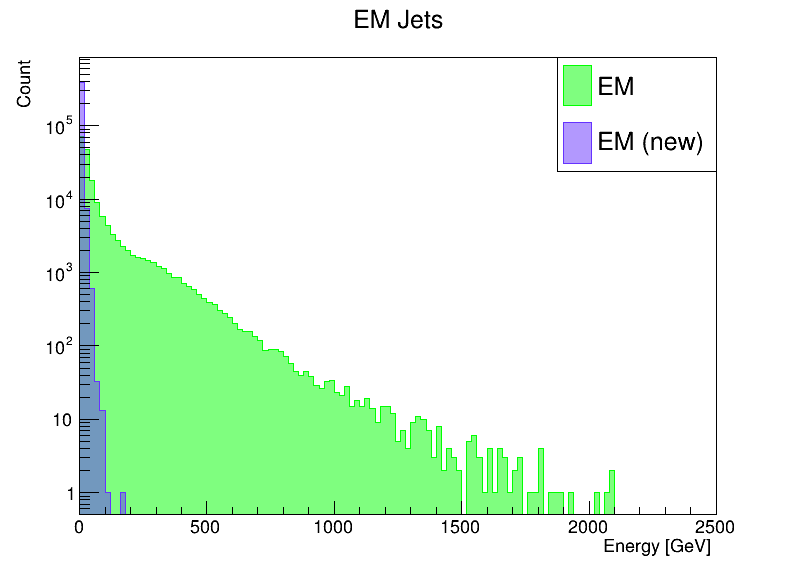

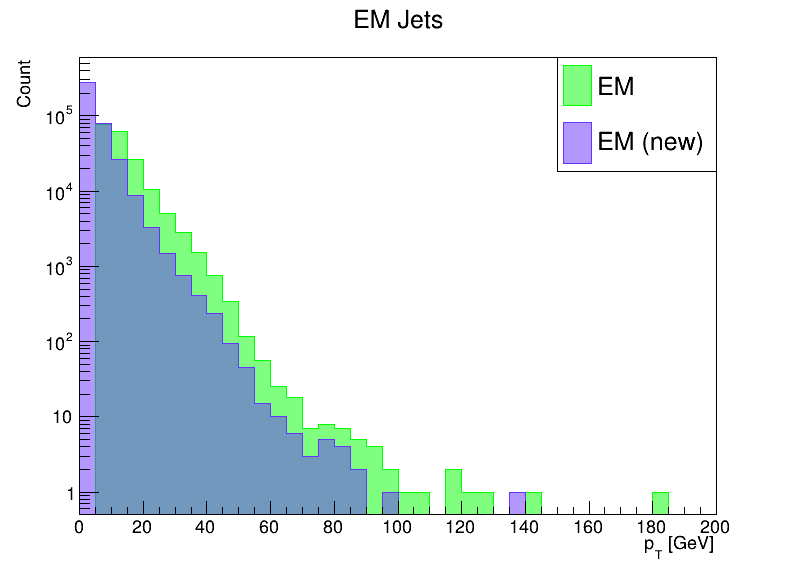

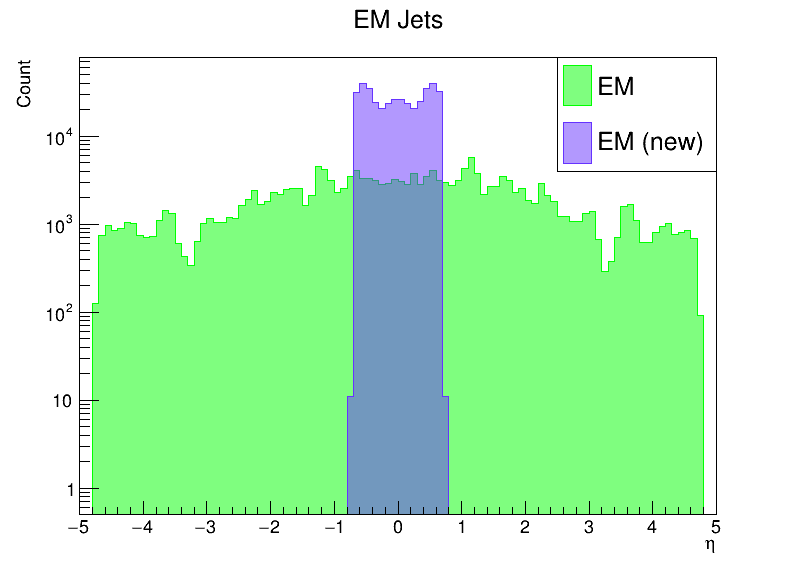

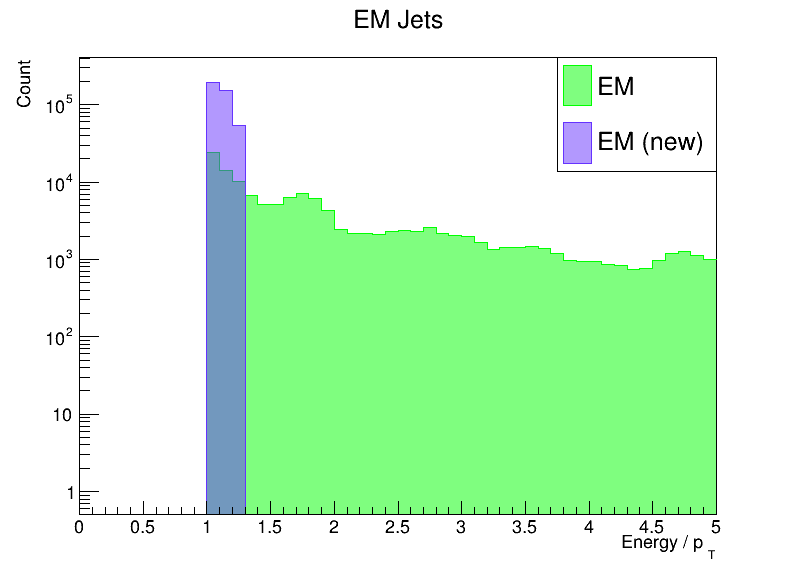

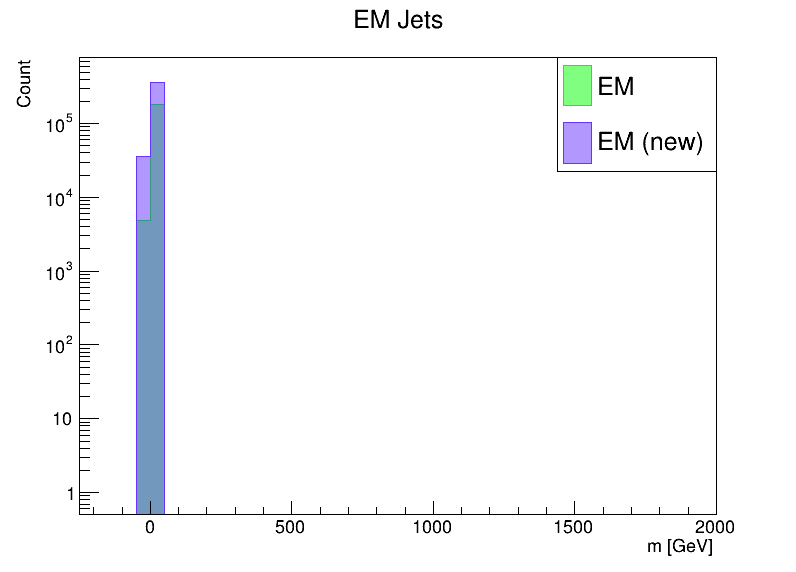

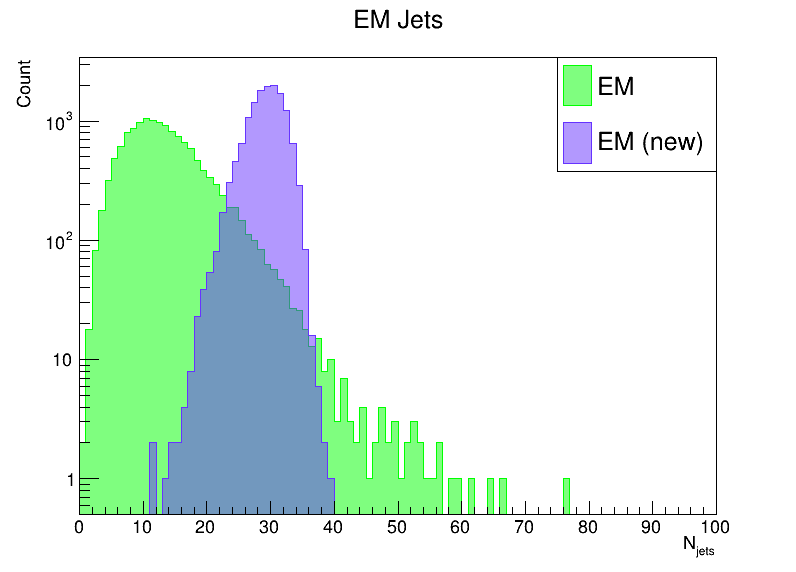

In [32]:
# plotting various jet energies divided by pT
jet_defs = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'EM2':('jet_em',   'AntiKt4EMTopoJets')
}

colors = {
    'EM': rt.kGreen,
    'EM2': rt.kViolet + 8
}

scale_factors = 0.001 # jet info seems to be in keV, we want to plot it all in GeV

energy_hists = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy [GeV];Count', 125, 0., 2500.) for key in jet_defs.keys()}
pt_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;p_{T} [GeV];Count', 40, 0., 200.) for key in jet_defs.keys()}
eta_hists    = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;#eta;Count', 100, -5., 5.) for key in jet_defs.keys()}
m_hists      = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;m [GeV];Count', 45, -250., 2000.) for key in jet_defs.keys()}
ep_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy / p_{T};Count', 50, 0., 5.) for key in jet_defs.keys()}
n_hists      = {key:rt.TH1I(str(uuid.uuid4()), key + ' Jets;N_{jets};Count', 100, 0., 100) for key in jet_defs.keys()}

vec = rt.Math.PtEtaPhiEVector()
for dfile in data_filenames:
    for key, jet_def in jet_defs.items():
        energy   = scale_factors * ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'E').flatten()
        pt       = scale_factors * ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'Pt').flatten()
        eta      =                 ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'Eta').flatten()
        ep       = energy / pt
        n = np.array([x.shape[0] for x in ur_trees[dfile][jet_def[0]].array(jet_def[1] + 'E')],dtype=np.dtype('i2'))
        
        for i in range(len(n)):
            n_hists[key].Fill(n[i])
        for i in range(len(ep)):
            energy_hists[key].Fill(energy[i])
            pt_hists[key].Fill(pt[i])
            eta_hists[key].Fill(eta[i])
            ep_hists[key].Fill(ep[i])
            vec.SetCoordinates(pt[i],eta[i],0.,energy[i])
            m_hists[key].Fill(vec.M())

hist_lists = [energy_hists, pt_hists, eta_hists, ep_hists, m_hists, n_hists]
for key in jet_defs.keys():
    for hist_list in hist_lists:
        SetColor(hist_list[key],colors[key])

legend = rt.TLegend(0.7,0.7,0.9,0.9)
legend.AddEntry(energy_hists['EM'],'EM','f')
legend.AddEntry(energy_hists['EM2'],'EM (new)','f')

rt.gStyle.SetOptStat(0)
canvases = []
stacks = []
for hist_list in hist_lists:
    c = rt.TCanvas(str(uuid.uuid4()), str(uuid.uuid4()), 800, 600)
    c.cd()
    c.SetLogy()
    stack = rt.THStack(str(uuid.uuid4()),'')
    stack.SetTitle(list(hist_list.values())[0].GetTitle())
    for key in hist_list.keys():
        stack.Add(hist_list[key])
    stack.Draw('NOSTACK HIST')
    legend.Draw()
    stack.GetXaxis().SetTitle(list(hist_list.values())[0].GetXaxis().GetTitle())
    stack.GetYaxis().SetTitle(list(hist_list.values())[0].GetYaxis().GetTitle())
    stack.SetMinimum(5.0e-1)
    canvases.append(c)
    stacks.append(stack)
    canvases[-1].Draw()

Hmmm... the energy and jet multiplicity distributions are *totally* different, the $p_T$ distributions are quite similar (with our new EM jets having some lower $p_T$ members as we anticipated). But that there's any big difference in the energy, eta and multiplicity distributions suggests that something odd is happening in jet clustering on our end. This warrants further investigation.

## Coding "Playground" below

As an experiment, let's try rescaling the energy ratios from earlier. Is the predicted energy maybe just off by some constant factor? It seems unlikely but it doesn't hurt to try and see if rescaling the histogram will give us a (sharp?) peak near unity.

In [17]:
mean = np.mean(jet_energy_ratios['ML'])
print(mean)

54810844.0


Ok, I think the mean is thrown off by an outlier. So we can try to rescale the distribution so that the *median* or histogram *mode* is at 1.

In [18]:
def DrawRescaledRatio(jet_energy_ratios, rescaling_factor, target_name):

    energy_ratio_rescaled = jet_energy_ratios['ML'] * rescaling_factor
    
    colors = {
        'EM':rt.kGreen,
        'LC':rt.kRed,
        'ML':rt.kBlue
    }
    min_ratio = 1.0e-3
    max_ratio = 1.0e1
    nbins = 10000

    hists = {key: rt.TH1F(key + 'ratio', key + ';E_{reco}/E_{true};Count',nbins,min_ratio,max_ratio) for key in ['EM','LC','ML']}
    for key in ['EM','LC']:
        SetColor(hists[key],colors[key])
        for entry in jet_energy_ratios[key]:
            hists[key].Fill(entry)

    # our rescaled ML jet histogram
    SetColor(hists['ML'],colors['ML'])
    for entry in energy_ratio_rescaled:
        hists['ML'].Fill(entry)

    legend = rt.TLegend(0.6,0.65,0.9,0.85)
    legend.SetBorderSize(0)

    stack = rt.THStack('stack2','Energy Ratio;E_{reco}/E_{truth};Count')

    for key, hist in hists.items():
        stack.Add(hist)
        name = key
        if(key == 'ML'): name = target_name
        legend.AddEntry(hist,name,'f')

    return stack, legend

Warning in <TROOT::Append>: Replacing existing TH1: EMratio (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LCratio (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MLratio (Potential memory leak).


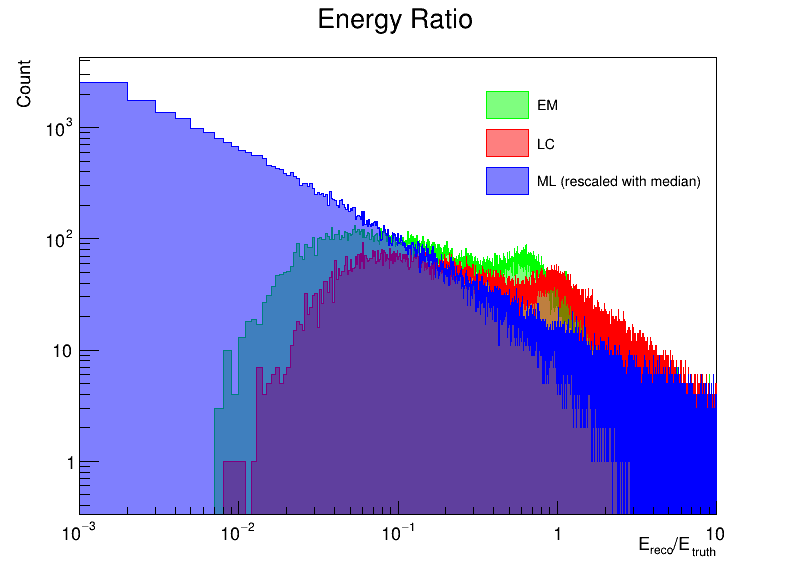

In [19]:
median = np.median(jet_energy_ratios['ML'])
rescaling_factor = 1. / median
stack, legend = DrawRescaledRatio(jet_energy_ratios, rescaling_factor, target_name='ML (rescaled with median)')

c = rt.TCanvas('c_ratio2','c_ratio2',800,600)
rt.gStyle.SetOptStat(0)
stack.Draw('NOSTACK HIST')
legend.Draw()
c.SetLogx()
c.SetLogy()
c.Draw()

Hmmm... rescaling the `ML` distribution to have a median of $1$ isn't quite cutting it. This suggests that there are a *lot* of events in the overflow bin.

Instead, let's try rescaling the distribution so that its peak is at $1$. Note that this is dependent on our choice of binning.

Warning in <TROOT::Append>: Replacing existing TH1: EMratio (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LCratio (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MLratio (Potential memory leak).


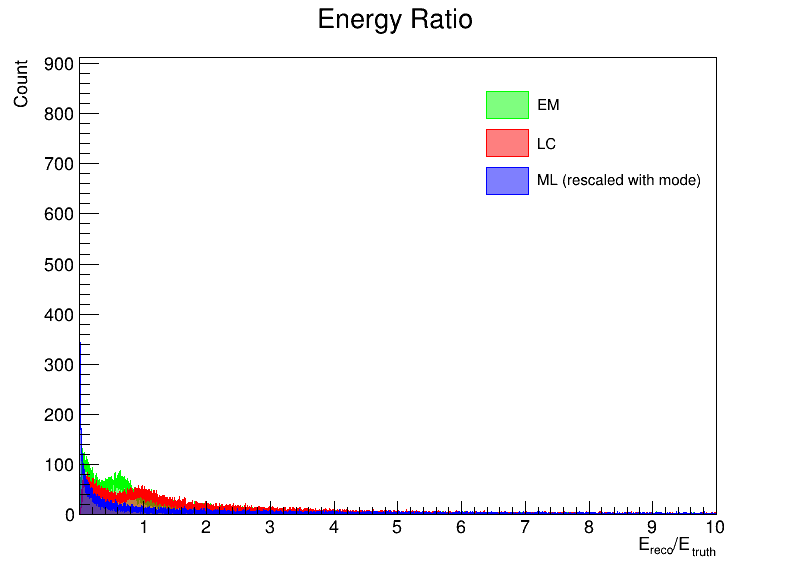

In [20]:
nbins_tmp = 10000
hists['ML'] = rt.TH1F(key + 'ratio', 'ML;E_{reco}/E_{true};Count',nbins_tmp,min_ratio,max_ratio)
for entry in jet_energy_ratios['ML']:
    hists['ML'].Fill(entry)
binmax = hists['ML'].GetMaximumBin()
mode = hists['ML'].GetXaxis().GetBinCenter(binmax)
rescaling_factor = 1. / mode

stack, legend = DrawRescaledRatio(jet_energy_ratios, rescaling_factor, target_name='ML (rescaled with mode)')
c = rt.TCanvas('c_ratio3','c_ratio3',800,600)
rt.gStyle.SetOptStat(0)
stack.Draw('NOSTACK HIST')
legend.Draw()
c.Draw()

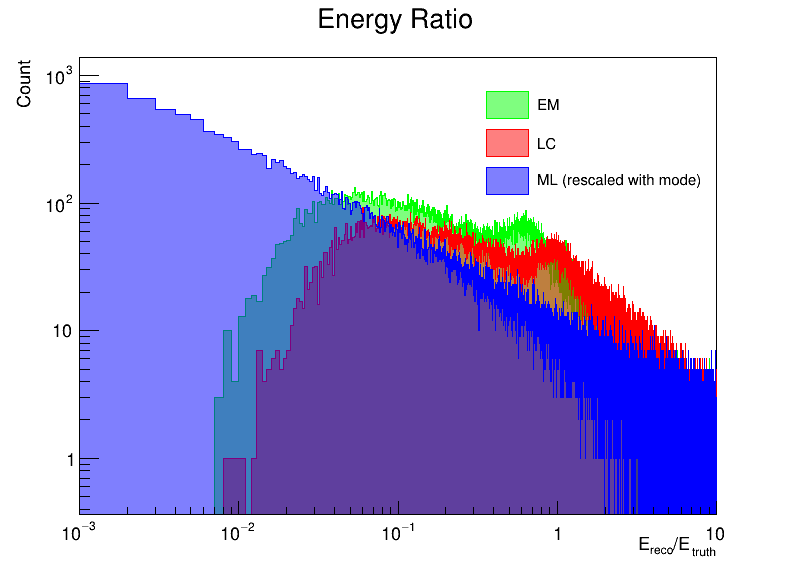

In [21]:
c.SetLogx()
c.SetLogy()
c.Draw()

Perhaps unsurprisingly, there doesn't seem to be any obvious scaling that will improve things -- as we might expect, rescaling will stretch things out (and increase spread).